# Emotional Speech Recognition
This notebook will be an audio classification problem and solved with Audio Feature extraction and augmentation, Machine Learning and Deep Learning. 

https://www.kaggle.com/dejolilandry/asvpesdspeech-nonspeech-emotional-utterances

In [61]:
import numpy as np 
import pandas as pd
import os 
import math
import torch 
import torchaudio 
import torch.nn as nn 
import torch.optim as optim
from tqdm import tqdm
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt 
#%matplotlib_inline
import seaborn as sns
import librosa 
import librosa.display

import IPython.display as ipd

from MyDataClasses import ASVPDataset

In [11]:
# Global Variables 

SAMPLE_RATE = 16000
N_FFT = int(0.025 * SAMPLE_RATE)   # 25 ms 
HOP_LENGTH = int(0.01 * SAMPLE_RATE)  # 10 ms
DURATION = 20 
N_SAMPLES = SAMPLE_RATE * DURATION 

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

ASVP_dir = '/Users/stephen/Desktop/Speech_Recognition/Data/ASVP-ESD_UPDATE/Audio/'
ASVP_metadata = '/Users/stephen/Desktop/Speech_Recognition/Data/ASVP-ESD_UPDATE/metadata.csv'

In [16]:
emotional_speech_dataset = ASVPDataset(
    annotations_file=ASVP_metadata, 
    audio_dir=ASVP_dir,
    target_sample_rate=SAMPLE_RATE, 
    num_samples=N_SAMPLES,
    device=device  
)

In [17]:
len(emotional_speech_dataset)

3946

In [18]:
emotional_speech_dataset[133]

(tensor([[0., 0., 0.,  ..., 0., 0., 0.]]), 'angry')

# Data Preperation 
Since the dataset didnt come with a CSV file containing the metadata we'll create a dataframe that contains the Path to the Wav file and it Class which is what emotion it has been labeled as. 

Taken from the Kaggle Dataset Descri

Each wav file in the dataset consists of numerical identifiers. 

Filename identifiers:
Modality ( 03 = audio-only).
Vocal channel on s(01 = speech, 02 = npeech).
Emotion ( 01 = boredom, 02 = neutral, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised, 09 = excited, 10 = pleasure, 11 = pain, 12 = disappointment, 13 = others).
Emotional intensity (01 = normal, 02 = high).
Statement (as it’s non scripted this refer to the number of sample select per actor folder ).
Actor ( even numbered acteurs are male, odd numbered actors are female).
Age(01 = above 65, 02 = between 20~64, 03 = under 20,04=new born).
Source of downloading (01 =website , 02 = youtube channel, 03= movies).
Language(01=Chinese , 02=English ,04 = french , others).



In [147]:
labels_dict = {
    1: 'boredom', 
    2: 'neutral',
    3: 'happy',
    4: 'sad',
    5: 'angry',
    6: 'fearful',
    7: 'disgust', 
    8: 'surprised',
    9: 'excited', 
    10: 'pleasure',
    11: 'pain', 
    12: 'disappointment', 
    13: 'others'
}

So by taking a look at how the data is labeled we can decide how to make classification for our problem. Lets start simple and just use the Emotion label. Later we can try classifying other labels like age and gender. We'll also only use files labeled as speech, later we'll use the non speech files for data augmentation but more on that later. for now lets make a list 

In [148]:
# lets practice taking the path strings apart 
ster = "/Users/stephen/Desktop/Speech_Commands/Data/ASVP-ESD_UPDATE/Audio/actor_103/03-01-05-01-07-103-02-01-02-18.wav"
part = ster.split('/')[-1]
part = part.split('.')[0]
part = part.split('-')
print(part)

['03', '01', '05', '01', '07', '103', '02', '01', '02', '18']


In [149]:
# string representing PATH for folder containing data
audio_path = '/Users/stephen/Desktop/Speech_Commands/Data/ASVP-ESD_UPDATE/Audio/'

# the dataset is organized into folders for each actor/actress. the listdir method will list all contained folders 
dir_list = os.listdir(audio_path)


file_emotion = []
file_path = []
file_fold = []

# iterate through files and 
for dir in dir_list:
    # extract contents from each folder 
    actor = os.listdir(audio_path + dir)
    # go through each file in each folder 
    for file in actor: 
        part = file.split('.')[0] # ignore the .wav
        part = part.split('-')
        # the second part represents speech or non speech 
        if part[1] == '01': # 01 represents Speech 
            # third part represents emotion 
            file_emotion.append(int(part[2]))
            file_path.append('/' + file)
            file_fold.append(dir)



# dataframe for emotion of files 
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files 
path_df = pd.DataFrame(file_path, columns=['Path'])

# dataframe for names of folders 
fold_df = pd.DataFrame(file_fold, columns=['Folder'])

metadata = pd.concat([emotion_df, path_df, fold_df], axis=1)

# change integers to actual emotions. 
metadata.Emotions.replace(labels_dict, inplace=True)
metadata.head()

,Emotions,Path,Folder
0,neutral,/03-01-02-01-02-16-03-03-01.wav,actor_16
1,angry,/03-01-05-02-07-16-03-03-01.wav,actor_16
2,neutral,/03-01-02-01-13-16-03-03-01.wav,actor_16
3,neutral,/03-01-02-01-05-16-03-03-01.wav,actor_16
4,angry,/03-01-05-02-06-16-03-03-01.wav,actor_16


In [1]:
metadata.info

NameError: name 'metadata' is not defined

In [150]:
# Sanity check to make sure the Path Column contains the fill path 
metadata['Path'][0]

'/03-01-02-01-02-16-03-03-01.wav'

In [151]:
# lets save to CSV file for later use. The PandasData frame will be used to visualize some data 
metadata.to_csv('/Users/stephen/Desktop/Speech_Commands/Data/ASVP-ESD_UPDATE/metadata.csv', index=False)

# Data Visualization 
lets makes some visuals 



In [152]:
metadata['Emotions'].value_counts()

neutral           1019
angry              987
happy              495
sad                471
surprised          327
disappointment     241
fearful            137
disgust             93
excited             92
pain                36
boredom             26
pleasure            22
Name: Emotions, dtype: int64

/Users/stephen/opt/anaconda3/envs/torch_env/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


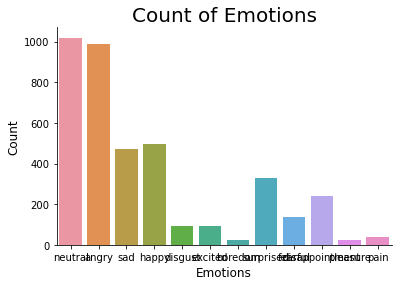

In [153]:
plt.title('Count of Emotions', size=20)
sns.countplot(metadata.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [ ]:
metadata

In [154]:
audio_path

'/Users/stephen/Desktop/Speech_Commands/Data/ASVP-ESD_UPDATE/Audio/'

In [196]:
d = pd.read_csv('/Users/stephen/Desktop/Speech_Commands/Data/ASVP-ESD_UPDATE/metadata.csv')
metadata.iloc[0, 2]

'actor_16'

In [189]:

print(audio_path + metadata.iloc[120, 2] + metadata.iloc[120, 1])


/Users/stephen/Desktop/Speech_Commands/Data/ASVP-ESD_UPDATE/Audio/actor_20/03-01-08-01-25-20-01-03-01.wav


# Data Preprossing 

not that we are able to locate our data properly we'll create a custom Dataset object with Pytorch. This will make it easier to work with 

In [208]:
# Pytorch Dataset class 

class EmotionalSpeechDataset(Dataset):
    # constructor 
    def __init__(self, annotations_file, audio_dir, target_sample_rate, num_samples, device, transformation=None): 
        self.annotations_file = annotations_file
        self.audio_dir = audio_dir 
        self.target_sample_rate = target_sample_rate
        self.num_samples = num_samples 
        self.device = device 
        self.transformation = transformation

    def __len__(self):
        return len(self.annotations_file)

    def __getitem__(self, index):
        audio_sample_path = self._get_audio_sample_path(index)
        label = self._get_audio_sample_label(index)
        signal, sr = torchaudio.load(audio_sample_path)
        signal = signal.to(self.device)
        signal = self._resample_if_necessary(signal, sr)
        signal = self._mix_down_if_necessary(signal)
        signal = self._cut_if_necessary(signal)
        signal = self._right_pad_if_necessary(signal)

        # if a transformation is stated, apply to audio tensor 
        if self.transformation: 
            signal = self.transformation(signal).to(self.device)
        return signal, label 

    def _cut_if_necessary(self, signal):
        if signal.shape[1] > self.num_samples:
            signal = signal[:, :self.num_samples]
        return signal 

    def _right_pad_if_necessary(self, signal): 
        length_signal = signal.shape[1]
        if length_signal < self.num_samples:    # compare each file with desired length 
            num_missing_samples = self.num_samples - length_signal 
            last_dim_padding = (0, num_missing_samples)
            signal = torch.nn.functional.pad(signal, last_dim_padding)
        return signal 

    def _resample_if_necessary(self, signal, sr):
        if sr != self.target_sample_rate:
            resampler = torchaudio.transforms.Resample(sr, self.target_sample_rate)
            signal = resampler(signal)
        return signal 

    def _mix_down_if_necessary(self, signal):  # if file is Stereo, convert to mono by using the mean 
        if signal.shape[0] > 1:
            signal = torch.mean(signal, dim=0, keepdim=True)
        return signal 

    def _get_audio_sample_path(self, index):
        #fold = f"fold{self.annotations.iloc[index, 2]}"    # grab from "Folder" column 
        #path = os.path.join(self.audio_dir, fold, self.annotations_file.iloc[index, 1]) # combine to make full PATH
        fold = self.annotations_file.iloc[index, 2]
        path = os.path.join(self.audio_dir + fold + self.annotations_file.iloc[index, 1])
        return path 
    
    def _get_audio_sample_label(self, index):
        return self.annotations_file.iloc[index, 0]  # grab from "label" column  



        

In [210]:
len(emotional_speech_dataset)

3946

In [19]:
emotional_speech_dataset[480][0].size()

torch.Size([1, 320000])

In [22]:
# helper functions 

def print_stats(waveform, sample_rate=None, src=None):
  if src:
    print("-" * 10)
    print("Source:", src)
    print("-" * 10)
  if sample_rate:
    print("Sample Rate:", sample_rate)
  print("Shape:", tuple(waveform.shape))
  print("Dtype:", waveform.dtype)
  print(f" - Max:     {waveform.max().item():6.3f}")
  print(f" - Min:     {waveform.min().item():6.3f}")
  print(f" - Mean:    {waveform.mean().item():6.3f}")
  print(f" - Std Dev: {waveform.std().item():6.3f}")
  print()
  print(waveform)
  print()

def plot_spectrogram(spec, title=None, ylabel='freq_bin', aspect='auto', xmax=None):
  fig, axs = plt.subplots(1, 1)
  axs.set_title(title or 'Spectrogram (db)')
  axs.set_ylabel(ylabel)
  axs.set_xlabel('frame')
  im = axs.imshow(librosa.power_to_db(spec), origin='lower', aspect=aspect)
  if xmax:
    axs.set_xlim((0, xmax))
  fig.colorbar(im, ax=axs)
  plt.show(block=False)

def plot_waveform(waveform, sample_rate, title="Waveform", xlim=None, ylim=None):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  time_axis = torch.arange(0, num_frames) / sample_rate

  figure, axes = plt.subplots(num_channels, 1)
  if num_channels == 1:
    axes = [axes]
  for c in range(num_channels):
    axes[c].plot(time_axis, waveform[c], linewidth=1)
    axes[c].grid(True)
    if num_channels > 1:
      axes[c].set_ylabel(f'Channel {c+1}')
    if xlim:
      axes[c].set_xlim(xlim)
    if ylim:
      axes[c].set_ylim(ylim)
  figure.suptitle(title)
  plt.show(block=False)

def play_audio(waveform, sample_rate):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  if num_channels == 1:
    display(Audio(waveform[0], rate=sample_rate))
  elif num_channels == 2:
    display(Audio((waveform[0], waveform[1]), rate=sample_rate))
  else:
    raise ValueError("Waveform with more than 2 channels are not supported.")

# Define a function to plot accuracy and loss

def plot_accuracy_loss(training_results): 
    plt.subplot(2, 1, 1)
    plt.plot(training_results['training_loss'], 'r')
    plt.ylabel('loss')
    plt.title('training loss iterations')
    plt.subplot(2, 1, 2)
    plt.plot(training_results['validation_accuracy'])
    plt.ylabel('accuracy')
    plt.xlabel('epochs')   
    plt.show()

# Define a function to plot model parameters


In [23]:
test_sample, test_label = emotional_speech_dataset[1000]
print(test_label, test_sample)

angry tensor([[0., 0., 0.,  ..., 0., 0., 0.]])


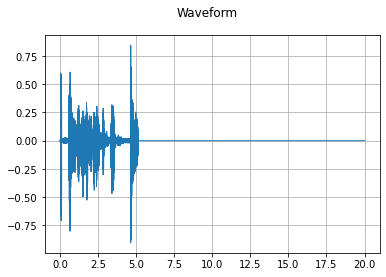

Shape: (1, 320000)
Dtype: torch.float32
 - Max:      0.845
 - Min:     -0.905
 - Mean:    -0.000
 - Std Dev:  0.038

tensor([[0., 0., 0.,  ..., 0., 0., 0.]])



In [24]:

plot_waveform(test_sample, 16000)
print_stats(test_sample)


Shape: (1, 513, 626)
Dtype: torch.float32
 - Max:     2473.296
 - Min:      0.000
 - Mean:     0.572
 - Std Dev: 13.657

tensor([[[1.0409e-01, 9.7380e-01, 4.4965e-02,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [5.8062e-02, 3.9924e-01, 1.1436e-01,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [1.5062e-03, 7.4051e-01, 5.9417e-02,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         ...,
         [2.8201e-08, 5.2569e-08, 2.2910e-08,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [3.2102e-08, 1.5199e-09, 3.1599e-08,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [9.2424e-08, 7.3771e-09, 4.7409e-08,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00]]])



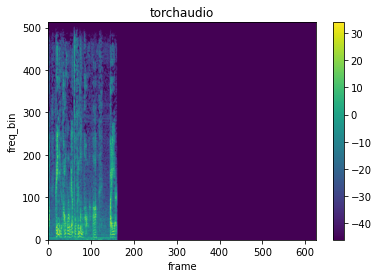

In [26]:
n_fft = 1024
win_length = None
hop_length = 512

# define transformation
spectrogram = torchaudio.transforms.Spectrogram(
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    center=True,
    pad_mode="reflect",
    power=2.0,
)
# Perform transformation
spec = spectrogram(test_sample)

print_stats(spec)
plot_spectrogram(spec[0], title='torchaudio')


# Split data into Train, Test and Validation sets 

In [27]:
total_count = len(emotional_speech_dataset)
train_count = int(0.7 * total_count)
valid_count = int(0.2 * total_count)
test_count = total_count - train_count - valid_count
print('Train count: ' + str(train_count))
print('validation count: ' + str(valid_count))
print('Test count: ' + str(test_count))

Train count: 2762
validation count: 789
Test count: 395


In [28]:
train_dataset, valid_dataset, test_dataset = torch.utils.data.random_split(emotional_speech_dataset, (train_count, valid_count, test_count))

In [29]:
labels = sorted(list(set(r[1] for r in train_dataset)))
labels


['angry',
 'boredom',
 'disappointment',
 'disgust',
 'excited',
 'fearful',
 'happy',
 'neutral',
 'pain',
 'pleasure',
 'sad',
 'surprised']

In [30]:
def label_to_index(word):
    # Return the position of the word in labels
    return torch.tensor(labels.index(word))


def index_to_label(index):
    # Return the word corresponding to the index in labels
    # This is the inverse of label_to_index
    return labels[index]

In [31]:
word_start = "neutral"
index = label_to_index(word_start)
word_recovered = index_to_label(index)

print(word_start, "-->", index, "-->", word_recovered)

neutral --> tensor(7) --> neutral


In [32]:
type(index)


torch.Tensor

In [33]:
new_sample_rate = 16000
transform = torchaudio.transforms.Resample(orig_freq=16000, new_freq=new_sample_rate)
transformed = transform(test_sample)

In [35]:
one_hot = torch.nn.functional.one_hot(index, 12)
one_hot

tensor([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0])

In [36]:
def pad_sequence(batch):
    # Make all tensor in a batch the same length by padding with zeros
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0.)
    return batch.permute(0, 2, 1)

def collate_fn(batch):

    # A data tuple has the form:
    # waveform, sample_rate, label, speaker_id, utterance_number

    tensors, targets = [], []

    # Gather in lists, and encode labels as indices
    for waveform, label in batch:
        tensors += [waveform]
        targets += [label_to_index(label)]

    # Group the list of tensors into a batched tensor
    tensors = pad_sequence(tensors)
    targets = torch.stack(targets)

    return tensors, targets

batch_size = 64
if device == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

In [39]:
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn, num_workers=num_workers, pin_memory=pin_memory)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, drop_last=False, collate_fn=collate_fn, num_workers=num_workers, pin_memory=pin_memory)

In [40]:
train_loader

# Model 

In [43]:
class M5(nn.Module):
    def __init__(self, n_input=1, n_output=8, stride=16, n_channel=32):
        super().__init__()
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=80, stride=stride)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.pool2 = nn.MaxPool1d(4)
        self.conv3 = nn.Conv1d(n_channel, 2 * n_channel, kernel_size=3)
        self.bn3 = nn.BatchNorm1d(2 * n_channel)
        self.pool3 = nn.MaxPool1d(4)
        self.conv4 = nn.Conv1d(2 * n_channel, 2 * n_channel, kernel_size=3)
        self.bn4 = nn.BatchNorm1d(2 * n_channel)
        self.pool4 = nn.MaxPool1d(4)
        self.fc1 = nn.Linear(2 * n_channel, n_output)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.pool4(x)
        x = F.avg_pool1d(x, x.shape[-1])
        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        return F.log_softmax(x, dim=2)

In [44]:
model = M5(n_input=test_sample.shape[0], n_output=len(labels))
model.to(device)
print(model)

M5(
  (conv1): Conv1d(1, 32, kernel_size=(80,), stride=(16,))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 32, kernel_size=(3,), stride=(1,))
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
  (bn4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=64, out_features=12, bias=True)
)


In [45]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


n = count_parameters(model)
print("Number of parameters: %s" % n)

Number of parameters: 25420


In [49]:
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)  # reduce the learning after 20 epochs by a factor of 10

# train net

In [50]:
lost_list = []
accuracy_list = [ ]
N_test=len(test_dataset)


def train(model, epoch, log_interval):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):

        #data = data.to(device)
        target = target.to(device)

        # apply transform and model on whole batch directly on device
        #data = transform(data)
        output = model(data)

        # negative log-likelihood for a tensor of size (batch x 1 x n_output)
        loss = F.nll_loss(output.squeeze(), target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print training stats
        if batch_idx % log_interval == 0:
            print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")

        # update progress bar
        pbar.update(pbar_update)
        # record loss
        losses.append(loss.item())

In [51]:
def number_of_correct(pred, target):
    # count number of correct predictions
    return pred.squeeze().eq(target).sum().item()


def get_likely_index(tensor):
    # find most likely label index for each element in the batch
    return tensor.argmax(dim=-1)


def test(model, epoch):
    model.eval()
    correct = 0
    for data, target in test_loader:

        #data = data.to(device)
        target = target.to(device)

        # apply transform and model on whole batch directly on device
        data = transform(data)
        output = model(data)

        pred = get_likely_index(output)
        correct += number_of_correct(pred, target)

        # update progress bar
        pbar.update(pbar_update)
        accuracy = correct / N_test
        accuracy_list.append(accuracy)     

    print(f"\nTest Epoch: {epoch}\tAccuracy: {correct}/{len(test_loader.dataset)} ({100. * correct / len(test_loader.dataset):.0f}%)\n")

In [62]:
log_interval = 20
n_epoch = 20

pbar_update = 1 / (len(train_loader) + len(test_loader))
losses = []

# The transform needs to live on the same device as the model and the data.
#transform = transform.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        train(model, epoch, log_interval)
        test(model, epoch)
        scheduler.step()

  0%|          | 0.0196078431372549/20 [00:02<47:56, 143.96s/it]

Train Epoch: 1 [0/2762 (0%)]	Loss: 2.553230


  2%|▏         | 0.41176470588235276/20 [00:43<35:33, 108.94s/it] 

Train Epoch: 1 [1280/2762 (45%)]	Loss: 1.791266


  4%|▍         | 0.8039215686274513/20 [01:22<32:22, 101.21s/it] 

Train Epoch: 1 [2560/2762 (91%)]	Loss: 1.730736


  5%|▌         | 1.0000000000000007/20 [01:33<13:37, 43.01s/it] 


Test Epoch: 1	Accuracy: 127/395 (32%)



  5%|▌         | 1.0196078431372555/20 [01:35<19:07, 60.44s/it]

Train Epoch: 2 [0/2762 (0%)]	Loss: 1.576479


  7%|▋         | 1.4117647058823521/20 [02:13<29:55, 96.58s/it]

Train Epoch: 2 [1280/2762 (45%)]	Loss: 1.622757


  9%|▉         | 1.8039215686274488/20 [02:52<29:44, 98.05s/it]

Train Epoch: 2 [2560/2762 (91%)]	Loss: 1.863296


 10%|▉         | 1.9999999999999971/20 [03:02<12:31, 41.77s/it]


Test Epoch: 2	Accuracy: 147/395 (37%)



 10%|█         | 2.019607843137252/20 [03:04<17:43, 59.13s/it] 

Train Epoch: 3 [0/2762 (0%)]	Loss: 1.778183


 12%|█▏        | 2.411764705882349/20 [03:42<28:25, 96.95s/it] 

Train Epoch: 3 [1280/2762 (45%)]	Loss: 1.882383


 14%|█▍        | 2.8039215686274455/20 [04:21<27:57, 97.53s/it]

Train Epoch: 3 [2560/2762 (91%)]	Loss: 1.733023


 15%|█▍        | 2.999999999999994/20 [04:31<11:49, 41.72s/it] 


Test Epoch: 3	Accuracy: 101/395 (26%)



 15%|█▌        | 3.0196078431372486/20 [04:33<16:45, 59.20s/it]

Train Epoch: 4 [0/2762 (0%)]	Loss: 1.615247


 17%|█▋        | 3.4117647058823453/20 [05:11<26:49, 97.02s/it]

Train Epoch: 4 [1280/2762 (45%)]	Loss: 1.833409


 19%|█▉        | 3.803921568627442/20 [05:49<26:21, 97.65s/it] 

Train Epoch: 4 [2560/2762 (91%)]	Loss: 1.617340


 20%|█▉        | 3.9999999999999902/20 [06:00<11:22, 42.64s/it]


Test Epoch: 4	Accuracy: 146/395 (37%)



 20%|██        | 4.019607843137245/20 [06:02<16:21, 61.40s/it] 

Train Epoch: 5 [0/2762 (0%)]	Loss: 1.766875


 22%|██▏       | 4.411764705882342/20 [06:41<25:27, 98.02s/it] 

Train Epoch: 5 [1280/2762 (45%)]	Loss: 1.345842


 24%|██▍       | 4.803921568627438/20 [07:19<24:43, 97.64s/it] 

Train Epoch: 5 [2560/2762 (91%)]	Loss: 1.586110


 25%|██▍       | 4.999999999999987/20 [07:29<10:14, 40.96s/it] 


Test Epoch: 5	Accuracy: 166/395 (42%)



 25%|██▌       | 5.0196078431372415/20 [07:31<14:20, 57.47s/it]

Train Epoch: 6 [0/2762 (0%)]	Loss: 1.581748


 27%|██▋       | 5.411764705882338/20 [08:09<23:40, 97.39s/it] 

Train Epoch: 6 [1280/2762 (45%)]	Loss: 1.489998


 29%|██▉       | 5.803921568627435/20 [08:47<22:59, 97.14s/it] 

Train Epoch: 6 [2560/2762 (91%)]	Loss: 1.767463


 30%|██▉       | 5.999999999999983/20 [08:57<09:30, 40.77s/it] 


Test Epoch: 6	Accuracy: 163/395 (41%)



 30%|███       | 6.019607843137238/20 [08:59<13:35, 58.31s/it]

Train Epoch: 7 [0/2762 (0%)]	Loss: 1.747639


 32%|███▏      | 6.411764705882335/20 [09:37<21:54, 96.76s/it] 

Train Epoch: 7 [1280/2762 (45%)]	Loss: 1.512050


 34%|███▍      | 6.803921568627431/20 [10:16<21:37, 98.35s/it]

Train Epoch: 7 [2560/2762 (91%)]	Loss: 1.536684


 35%|███▍      | 6.99999999999998/20 [10:26<09:03, 41.84s/it] 


Test Epoch: 7	Accuracy: 166/395 (42%)



 35%|███▌      | 7.019607843137234/20 [10:28<12:34, 58.13s/it]

Train Epoch: 8 [0/2762 (0%)]	Loss: 1.498891


 37%|███▋      | 7.411764705882331/20 [11:06<20:36, 98.19s/it] 

Train Epoch: 8 [1280/2762 (45%)]	Loss: 1.469155


 39%|███▉      | 7.803921568627428/20 [11:44<19:35, 96.38s/it] 

Train Epoch: 8 [2560/2762 (91%)]	Loss: 1.876808


 40%|███▉      | 7.999999999999976/20 [11:54<08:11, 40.93s/it] 


Test Epoch: 8	Accuracy: 132/395 (33%)



 40%|████      | 8.019607843137232/20 [11:56<11:31, 57.72s/it]

Train Epoch: 9 [0/2762 (0%)]	Loss: 1.843421


 42%|████▏     | 8.411764705882328/20 [12:34<18:38, 96.51s/it]

Train Epoch: 9 [1280/2762 (45%)]	Loss: 1.669103


 44%|████▍     | 8.803921568627425/20 [13:12<18:46, 100.63s/it]

Train Epoch: 9 [2560/2762 (91%)]	Loss: 1.365881


 45%|████▍     | 8.999999999999973/20 [13:23<07:45, 42.35s/it] 


Test Epoch: 9	Accuracy: 161/395 (41%)



 45%|████▌     | 9.019607843137228/20 [13:25<10:47, 58.96s/it]

Train Epoch: 10 [0/2762 (0%)]	Loss: 1.454532


 47%|████▋     | 9.411764705882325/20 [14:03<17:04, 96.78s/it]

Train Epoch: 10 [1280/2762 (45%)]	Loss: 1.480600


 49%|████▉     | 9.803921568627421/20 [14:40<16:25, 96.70s/it]

Train Epoch: 10 [2560/2762 (91%)]	Loss: 1.653352


 50%|████▉     | 9.99999999999997/20 [14:51<06:44, 40.40s/it] 


Test Epoch: 10	Accuracy: 147/395 (37%)



 50%|█████     | 10.019607843137225/20 [14:53<09:37, 57.90s/it]

Train Epoch: 11 [0/2762 (0%)]	Loss: 1.658283


 52%|█████▏    | 10.411764705882321/20 [15:30<15:20, 95.98s/it]

Train Epoch: 11 [1280/2762 (45%)]	Loss: 1.402858


 54%|█████▍    | 10.803921568627418/20 [16:09<15:26, 100.73s/it]

Train Epoch: 11 [2560/2762 (91%)]	Loss: 1.354939


 55%|█████▍    | 10.999999999999966/20 [16:19<06:10, 41.21s/it] 


Test Epoch: 11	Accuracy: 149/395 (38%)



 55%|█████▌    | 11.019607843137221/20 [16:21<08:47, 58.73s/it]

Train Epoch: 12 [0/2762 (0%)]	Loss: 1.321237


 57%|█████▋    | 11.411764705882318/20 [16:59<13:47, 96.32s/it]

Train Epoch: 12 [1280/2762 (45%)]	Loss: 1.605893


 59%|█████▉    | 11.803921568627414/20 [17:37<13:12, 96.74s/it]

Train Epoch: 12 [2560/2762 (91%)]	Loss: 1.482714


 60%|█████▉    | 11.999999999999963/20 [17:47<05:28, 41.05s/it]


Test Epoch: 12	Accuracy: 165/395 (42%)



 60%|██████    | 12.019607843137218/20 [17:49<07:39, 57.64s/it]

Train Epoch: 13 [0/2762 (0%)]	Loss: 1.666080


 62%|██████▏   | 12.411764705882314/20 [18:27<12:11, 96.36s/it]

Train Epoch: 13 [1280/2762 (45%)]	Loss: 1.532844


 64%|██████▍   | 12.80392156862741/20 [19:05<11:39, 97.14s/it] 

Train Epoch: 13 [2560/2762 (91%)]	Loss: 1.501418


 65%|██████▍   | 12.99999999999996/20 [19:15<04:48, 41.27s/it] 


Test Epoch: 13	Accuracy: 151/395 (38%)



 65%|██████▌   | 13.019607843137214/20 [19:17<06:50, 58.85s/it]

Train Epoch: 14 [0/2762 (0%)]	Loss: 1.707955


 67%|██████▋   | 13.41176470588231/20 [19:55<10:32, 96.02s/it] 

Train Epoch: 14 [1280/2762 (45%)]	Loss: 1.713136


 69%|██████▉   | 13.803921568627407/20 [20:33<10:06, 97.91s/it]

Train Epoch: 14 [2560/2762 (91%)]	Loss: 1.448124


 70%|██████▉   | 13.999999999999956/20 [20:44<04:08, 41.50s/it]


Test Epoch: 14	Accuracy: 114/395 (29%)



 70%|███████   | 14.01960784313721/20 [20:46<05:46, 57.89s/it] 

Train Epoch: 15 [0/2762 (0%)]	Loss: 1.571405


 72%|███████▏  | 14.411764705882307/20 [21:24<09:00, 96.79s/it]

Train Epoch: 15 [1280/2762 (45%)]	Loss: 1.549432


 74%|███████▍  | 14.803921568627404/20 [22:02<08:28, 97.77s/it]

Train Epoch: 15 [2560/2762 (91%)]	Loss: 1.218426


 75%|███████▍  | 14.999999999999952/20 [22:12<03:32, 42.45s/it]


Test Epoch: 15	Accuracy: 165/395 (42%)



 75%|███████▌  | 15.019607843137207/20 [22:14<04:52, 58.69s/it]

Train Epoch: 16 [0/2762 (0%)]	Loss: 1.674777


 77%|███████▋  | 15.411764705882304/20 [22:52<07:28, 97.71s/it]

Train Epoch: 16 [1280/2762 (45%)]	Loss: 1.390601


 79%|███████▉  | 15.8039215686274/20 [23:31<06:44, 96.49s/it]  

Train Epoch: 16 [2560/2762 (91%)]	Loss: 1.435217


 80%|███████▉  | 15.999999999999948/20 [23:41<02:46, 41.73s/it]


Test Epoch: 16	Accuracy: 166/395 (42%)



 80%|████████  | 16.019607843137205/20 [23:43<04:02, 60.98s/it]

Train Epoch: 17 [0/2762 (0%)]	Loss: 1.454840


 82%|████████▏ | 16.4117647058823/20 [24:21<05:47, 96.79s/it]  

Train Epoch: 17 [1280/2762 (45%)]	Loss: 1.653405


 84%|████████▍ | 16.8039215686274/20 [24:59<05:04, 95.39s/it]  

Train Epoch: 17 [2560/2762 (91%)]	Loss: 1.543747


 85%|████████▍ | 16.999999999999947/20 [25:09<02:03, 41.08s/it]


Test Epoch: 17	Accuracy: 152/395 (38%)



 85%|████████▌ | 17.0196078431372/20 [25:11<02:54, 58.67s/it]  

Train Epoch: 18 [0/2762 (0%)]	Loss: 1.419381


 87%|████████▋ | 17.411764705882298/20 [25:49<04:06, 95.36s/it]

Train Epoch: 18 [1280/2762 (45%)]	Loss: 2.029417


 89%|████████▉ | 17.803921568627395/20 [26:28<03:32, 96.98s/it] 

Train Epoch: 18 [2560/2762 (91%)]	Loss: 1.372485


 90%|████████▉ | 17.999999999999943/20 [26:38<01:23, 41.86s/it]


Test Epoch: 18	Accuracy: 140/395 (35%)



 90%|█████████ | 18.019607843137198/20 [26:40<01:57, 59.28s/it]

Train Epoch: 19 [0/2762 (0%)]	Loss: 1.278279


 92%|█████████▏| 18.411764705882295/20 [27:18<02:34, 96.98s/it]

Train Epoch: 19 [1280/2762 (45%)]	Loss: 1.364608


 94%|█████████▍| 18.80392156862739/20 [27:56<01:55, 96.31s/it] 

Train Epoch: 19 [2560/2762 (91%)]	Loss: 1.457095


 95%|█████████▍| 18.99999999999994/20 [28:06<00:41, 41.16s/it] 


Test Epoch: 19	Accuracy: 172/395 (44%)



 95%|█████████▌| 19.019607843137194/20 [28:08<00:57, 58.37s/it]

Train Epoch: 20 [0/2762 (0%)]	Loss: 1.410683


 97%|█████████▋| 19.41176470588229/20 [28:46<00:56, 96.24s/it] 

Train Epoch: 20 [1280/2762 (45%)]	Loss: 1.410479


 99%|█████████▉| 19.803921568627388/20 [29:24<00:19, 97.38s/it]

Train Epoch: 20 [2560/2762 (91%)]	Loss: 1.438594


100%|█████████▉| 19.999999999999936/20 [29:35<00:00, 88.76s/it]


Test Epoch: 20	Accuracy: 159/395 (40%)



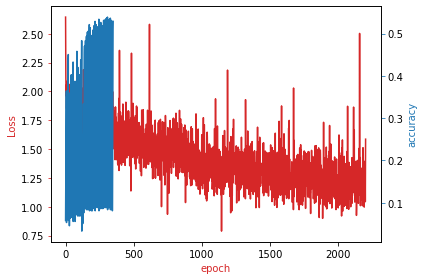

In [ ]:
# Plot the loss and accuracy

fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.plot(losses, color=color)
ax1.set_xlabel('epoch', color=color)
ax1.set_ylabel('Loss', color=color)
ax1.tick_params(axis='y', color=color)
    
ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('accuracy', color=color) 
ax2.set_xlabel('epoch', color=color)
ax2.plot( accuracy_list, color=color)
ax2.tick_params(axis='y', color=color)
fig.tight_layout()


# Define a function to plot accuracy and loss

def plot_accuracy_loss(training_results): 
    plt.subplot(2, 1, 1)
    plt.plot(training_results['training_loss'], 'r')
    plt.ylabel('loss')
    plt.title('training loss iterations')
    plt.subplot(2, 1, 2)
    plt.plot(training_results['validation_accuracy'])
    plt.ylabel('accuracy')
    plt.xlabel('epochs')   
    plt.show()

# Define a function to plot model parameters

def print_model_parameters(model):
    count = 0
    for ele in model.state_dict():
        count += 1
        if count % 2 != 0:
            print ("The following are the parameters for the layer ", count // 2 + 1)
        if ele.find("bias") != -1:
            print("The size of bias: ", model.state_dict()[ele].size())
        else:
            print("The size of weights: ", model.state_dict()[ele].size())

In [ ]:
def predict(tensor):
    # Use the model to predict the label of the waveform
    tensor = tensor.to(device)
    tensor = transform(tensor)
    tensor = model(tensor.unsqueeze(0))
    tensor = get_likely_index(tensor)
    tensor = index_to_label(tensor.squeeze())
    return tensor


waveform, label = train_dataset[-1]
#ipd.Audio(waveform.numpy(), rate=sample_rate)

print(f"Expected: {label}. Predicted: {predict(waveform)}.")

Expected: disappointment. Predicted: sad.
